## Video Vision Transformer

In [43]:
import cv2
import os
import math
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import keras
from keras import layers, ops
import matplotlib.pyplot as plt
keras.utils.set_random_seed(42)
tf.data.experimental.enable_debug_mode()
tf.config.run_functions_eagerly(True) 
# os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

## Parameters

In [5]:
# `##` --> Adjustable

# DATA
IMG_SIZE = 128  ## Image size (128, 128) in this case
CHAN_SIZE = 1   # 1-GrayScale; 3-RGB
BATCH_SIZE = 8  ## 16, 32
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (50, IMG_SIZE, IMG_SIZE, CHAN_SIZE)
NUM_CLASSES = 2  # 1-Crash; 0-Normal

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
# EPOCHS = 10

# TUBELET EMBEDDING
PATCH_SIZE = (8,8,8) ##
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
EMBED_DIM = 64   ## Size of the feature vectors transformed from the input
NUM_HEADS =  6   ##
NUM_LAYERS = 6   ##

## 111 Retrieve videos for training, validating, and testing

In [2]:
# retrieve all video name

frames_path = 'data/frames/'
frames_path_normal = 'data/frames/Normal/'
frames_path_crash = 'data/frames/Crash/'

frames_name_normal = sorted([f for f in os.listdir(frames_path_normal)])
frames_name_crash = sorted([f for f in os.listdir(frames_path_crash)])

In [ ]:
#how many data needed
num_normal = 50
num_crash = 50

frames_name_normal = random.sample(frames_name_normal, num_normal)
frames_name_crash = random.sample(frames_name_crash, num_crash)

In [ ]:
# 6:2:2.5 train test split

train_normal, test_normal = train_test_split(frames_name_normal,test_size=0.3, random_state=42)
train_crash, test_crash = train_test_split(frames_name_crash, test_size=0.3, random_state=42)

temporary_normal, test_normal = train_test_split(frames_name_normal, test_size=0.2, random_state=42)
temporary_crash, test_crash = train_test_split(frames_name_crash, test_size=0.2, random_state=42)

train_normal, val_normal = train_test_split(temporary_normal, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2
train_crash, val_crash = train_test_split(temporary_crash, test_size=0.25, random_state=42)    # 0.25 * 0.8 = 0.2

In [ ]:
print("Normal Training Videos:", train_normal)
print("Crash Training Videos:", train_crash)
print("Normal Validation Videos:", val_normal)
print("Crash Validation Videos:", val_crash)
print("Normal Test Videos:", test_normal)
print("Crash Test Videos:", test_crash)

## Data Preprocessing

In [6]:
# Transform image to matrix format

def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=CHAN_SIZE)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0 # Normalization
    return image

train_videos = []
test_videos = []
train_labels = []
test_labels = []

for t in train_normal:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_normal + t + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_normal + t + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    train_videos.append(video.numpy())
    train_labels.append(0)
    
for t in test_normal:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_normal + t + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_normal + t + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    test_videos.append(video.numpy())
    test_labels.append(0)

for t in train_crash:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_crash + t + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_crash + t + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    train_videos.append(video.numpy())
    train_labels.append(1)
    
for t in test_crash:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_crash + t + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_crash + t + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    test_videos.append(video.numpy())
    test_labels.append(1)

    
valid_videos = []
valid_labels = []
    
for t in frames_name_crash_valid:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_crash + t + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_crash + t + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    valid_videos.append(video.numpy())
    valid_labels.append(1)

for t in frames_name_normal_valid:
    video = []
    for i in range(50):
        current_frame_index = str(i)
        if (i < 10):
            video.append(load_image(frames_path_crash + t + "/frame_000" + str(i) + ".jpg"))
        else:
            video.append(load_image(frames_path_crash + t + "/frame_00" + str(i) + ".jpg"))
    video = tf.stack(video)
    valid_videos.append(video.numpy())
    valid_labels.append(0)

    
train_videos = np.asarray(train_videos)
test_videos = np.asarray(test_videos)
train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)
valid_videos = np.asarray(valid_videos)
valid_labels = np.asarray(valid_labels)

# print(len(train_videos), len(train_labels)) # 34, 34
# print(len(test_videos), len(test_labels)) # 16, 16

In [9]:
# Create Dataloader

def preprocess(frames: tf.Tensor, label: tf.Tensor):
    """Preprocess the frames tensors and parse the labels."""
    # Preprocess images
    frames = tf.image.convert_image_dtype(
        frames[
            ..., tf.newaxis
        ],  # The new axis is to help for further processing with Conv3D layers
        tf.float32,
    )
    # Parse label
    label = tf.cast(label, tf.float32)
    return frames, label


def prepare_dataloader(
    videos: np.ndarray,
    labels: np.ndarray,
    loader_type: str = "train",
    batch_size: int = BATCH_SIZE,
):
    """Utility function to prepare the dataloader."""
    dataset = tf.data.Dataset.from_tensor_slices((videos, labels))

    if loader_type == "train":
        dataset = dataset.shuffle(BATCH_SIZE * 2)

    dataloader = (
        dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
    )
    return dataloader


trainloader = prepare_dataloader(train_videos, train_labels, "train")
testloader = prepare_dataloader(test_videos, test_labels, "test")
validloader = prepare_dataloader(valid_videos, valid_labels, "valid")

# Create Embedding Mechanism

class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        
        # `projected_patches`
        # dividing the input into patches (determined by kernel_size and strides) 
        # and transforming each patch into an 64-dimensional embedding.
        
        projected_patches = self.projection(videos) 
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches

# Create Positional Mechanism

class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = ops.arange(0, num_tokens, 1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

# class CustomMultiHeadAttention(layers.Layer):
#     def __init__(self, num_heads, key_dim, dropout=0, **kwargs):
#         super().__init__(**kwargs)
#         self.attention = layers.MultiHeadAttention(
#             num_heads=num_heads, key_dim=key_dim, dropout=dropout
#         )
#     def call(self, query, value):
#         attention_output, attention_scores = self.attention(query, value, value)
#         return attention_output, attention_scores

## 111 Run Model

In [87]:
""" REFERENCE

IMG_SIZE = 128
CHAN_SIZE = 1
BATCH_SIZE = 8
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (50, IMG_SIZE, IMG_SIZE, CHAN_SIZE)
NUM_CLASSES = 2

LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

PATCH_SIZE = (8,8,8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

LAYER_NORM_EPS = 1e-6
EMBED_DIM = 64
NUM_HEADS =  6
NUM_LAYERS = 6

"""

def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=EMBED_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES
):
    # Get the input layer
    inputs = layers.Input(shape=input_shape) # shape=(50,128,128,1)
    # Create patches
    patches = tubelet_embedder(inputs)
    # Encode patches
    encoded_patches = positional_encoder(patches)

    for _ in range(transformer_layers):
        
        # 1. Layer normalization and MultiHeadAttention
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        
        # 2. The MultiHeadAttention
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)
        
        # 3. Skip connection - Add output from dense layers to earlier layer normalization
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # 4. Layer Normalization and MultiLayerPerception
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # 5. The two fully-connected layers with GELU activation functions
        x4 = layers.Dropout(0.1)(layers.Dense(units=embed_dim, activation='gelu')(x3))
        x5 = layers.Dropout(0.1)(layers.Dense(units=embed_dim, activation='gelu')(x4))
        
        # 6. Skip connection - Add output from dense layers to earlier layer normalization
        encoded_patches = layers.Add()([x5, x2])

    # Layer normalization and Global average pooling
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [233]:
def run_experiment(callback=None):
    # Initialize model
    model = create_vivit_classifier(
        tubelet_embedder=TubeletEmbedding(
            embed_dim=EMBED_DIM, patch_size=PATCH_SIZE
        ),
        positional_encoder=PositionalEncoder(embed_dim=EMBED_DIM)
    )

    # Compile the model with the optimizer, loss function and the metrics.
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    # Train the model
    # You may definn the epochs here
    if (callback != None):
        history = model.fit(trainloader, epochs=5, validation_data=validloader)
    else:
        history = model.fit(trainloader, epochs=5, validation_data=validloader, callbacks=callback)

    return model, history

model, history = run_experiment()

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 10s/step - accuracy: 0.4103 - loss: 1.0987 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 1.2605 - val_top-5-accuracy: 1.0000
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 10s/step - accuracy: 0.5022 - loss: 0.7903 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 1.0095 - val_top-5-accuracy: 1.0000
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 51s 10s/step - accuracy: 0.6001 - loss: 0.5998 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.7285 - val_top-5-accuracy: 1.0000
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 53s 10s/step - accuracy: 0.7769 - loss: 0.4372 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 1.0464 - val_top-5-accuracy: 1.0000
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 54s 10s/step - accuracy: 0.8729 - loss: 0.4639 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 1.1870 - val_top-5-accuracy: 1.0000


In [89]:
model.summary()

Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33      │ (None, 50, 128,   │          0 │ -                 │
│ (InputLayer)        │ 128, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tubelet_embedding_… │ (None, 1536, 64)  │     32,832 │ input_layer_33[0… │
│ (TubeletEmbedding)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoder… │ (None, 1536, 64)  │     98,304 │ tubelet_embeddin… │
│ (PositionalEncoder) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1536, 64)  │        128 │ positional_encod… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1536, 64)  │     15,604 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_73 (Add)        │ (None, 1536, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1536, 64)  │        128 │ add_73[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 1536, 64)  │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_80          │ (None, 1536, 64)  │          0 │ dense_42[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 1536, 64)  │      4,160 │ dropout_80[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_81          │ (None, 1536, 64)  │          0 │ dense_43[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_74 (Add)        │ (None, 1536, 64)  │          0 │ dropout_81[0][0], │
│                     │                   │            │ add_73[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1536, 64)  │        128 │ add_74[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1536, 64)  │     15,604 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_75 (Add)        │ (None, 1536, 64)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_74[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1536, 64)  │        128 │ add_75[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 1536, 64)  │      4,160 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_83          │ (None, 1536, 64)  │          0 │ dense_44[0][0]  

 Total params: 829,424 (3.16 MB)

 Trainable params: 276,474 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 552,950 (2.11 MB)

## Visualization

## 1. Model Evaluation

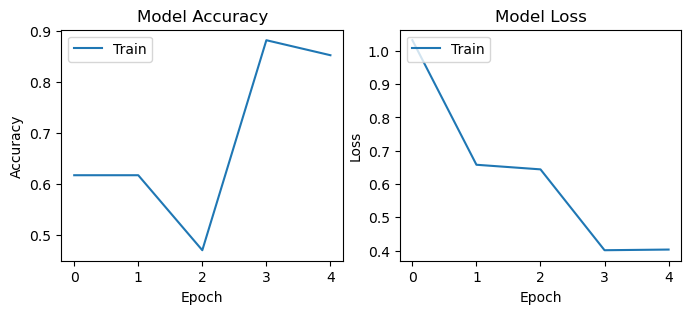

In [139]:
# Accuracy and Loss
plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

## 2. Model Analysis

### 2.1 Result Evaluation  - Bias towards Classifying Videos to Normal Class

In [30]:
# Evaluate 16 testing videos

model_predict_test = model.predict(testloader)

# Inspect Test Results

pred = []
normal_count = 0
misclassified_indicies = []

for i in range(16):
    crash_conf = model_predict_test[i][0]
    normal_conf = model_predict_test[i][1]
    if (crash_conf > normal_conf):
        print("Prediction: Crash", crash_conf)
        pred.append(1)
    else:
        print("Prediction: Normal", normal_conf)
        pred.append(0)
        normal_count += 1
    if (i < 8):
        print("Actual:     Crash", test_normal[i]+".mp4")
    else:
        print("Actual:     Normal", test_crash[abs(i-8)]+".mp4")
    print()
print(str(abs(len(test_labels)-normal_count)) + " videos out of 16 videos are classified as Crash")
print(str(normal_count) + " videos out of 16 videos are classified as Normal")

Prediction: Crash 0.7548805
Actual:     Crash 000009.mp4

Prediction: Crash 0.75127983
Actual:     Crash 000017.mp4

Prediction: Normal 0.7676368
Actual:     Crash 000001.mp4

Prediction: Crash 0.9392463
Actual:     Crash 000024.mp4

Prediction: Normal 0.7431279
Actual:     Crash 000012.mp4

Prediction: Normal 0.74492264
Actual:     Crash 000010.mp4

Prediction: Crash 0.77647525
Actual:     Crash 000014.mp4

Prediction: Normal 0.8125053
Actual:     Crash 000002.mp4

Prediction: Normal 0.87398434
Actual:     Normal 000009.mp4

Prediction: Normal 0.9165446
Actual:     Normal 000017.mp4

Prediction: Normal 0.7816835
Actual:     Normal 000001.mp4

Prediction: Normal 0.86163145
Actual:     Normal 000024.mp4

Prediction: Normal 0.7778499
Actual:     Normal 000012.mp4

Prediction: Normal 0.6390752
Actual:     Normal 000010.mp4

Prediction: Normal 0.8812375
Actual:     Normal 000014.mp4

Prediction: Normal 0.7696762
Actual:     Normal 000002.mp4

4 videos out of 16 videos are classified as Cra

### 2.2 Weight and Bias 

In [97]:
# # If interested in knowing what techniques are used for each layer
# for layer in model.layers:
#     print(layer.__class__.__name__)

In [133]:
# Extract Weights and Biases from the Two Dense Layers
weights,biases = model.layers[-1].get_weights()
# print(np.array(weights.shape)) # [64  2], 64 embedding layers with 2 classes

# Biases
print("Biases")
print(np.array(biases))  # [-0.00016644  0.00016644]

# Weights
print("\nWeights")
pd.DataFrame(weights)

Biases
[-0.00016644  0.00016644]

Weights


,0,1
0,0.246554,0.188509
1,0.130325,-0.209787
2,0.269725,0.095264
3,-0.108671,-0.077639
4,0.284937,0.023149
...,...,...
59,-0.205528,0.297354
60,-0.114503,0.204349
61,-0.009498,0.217742
62,0.107025,-0.224709


In [128]:
print(max(pd.DataFrame(weights).iloc[:,0]), min(pd.DataFrame(weights).iloc[:,0]), \
      max(pd.DataFrame(weights).iloc[:,1]), min(pd.DataFrame(weights).iloc[:,1]))

0.29214125871658325 -0.3015252947807312 0.2973538935184479 -0.3005257844924927


### (i) Overall weights and biases

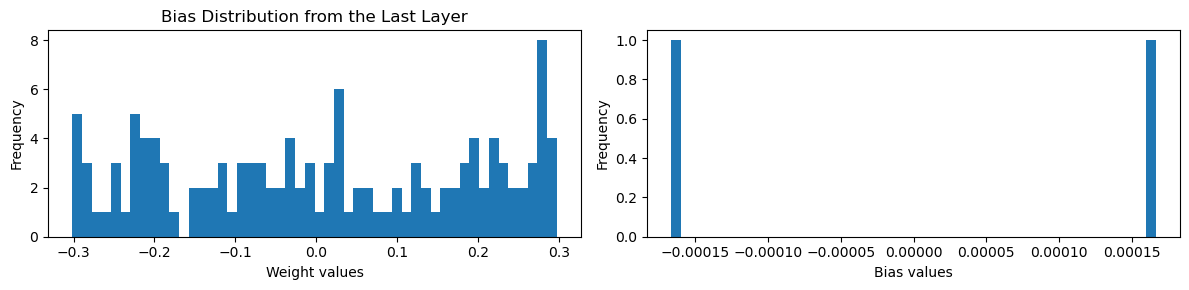

In [141]:
# Plotting

plt.figure(figsize=(12, 3))

# Weight Distribution
plt.subplot(1, 2, 1)
plt.title("Weight Distribution of the Last Layer")
plt.hist(weights.flatten(), bins=50)
plt.xlabel("Weight values")
plt.ylabel("Frequency")

# Bias Distribution
plt.title("Bias Distribution from the Last Layer")
plt.subplot(1, 2, 2)
plt.hist(biases.flatten(), bins=50)
plt.xlabel("Bias values")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### (ii) For each feature, does it contribute POSITIVELY or NEGATIVELY to each of the classification?

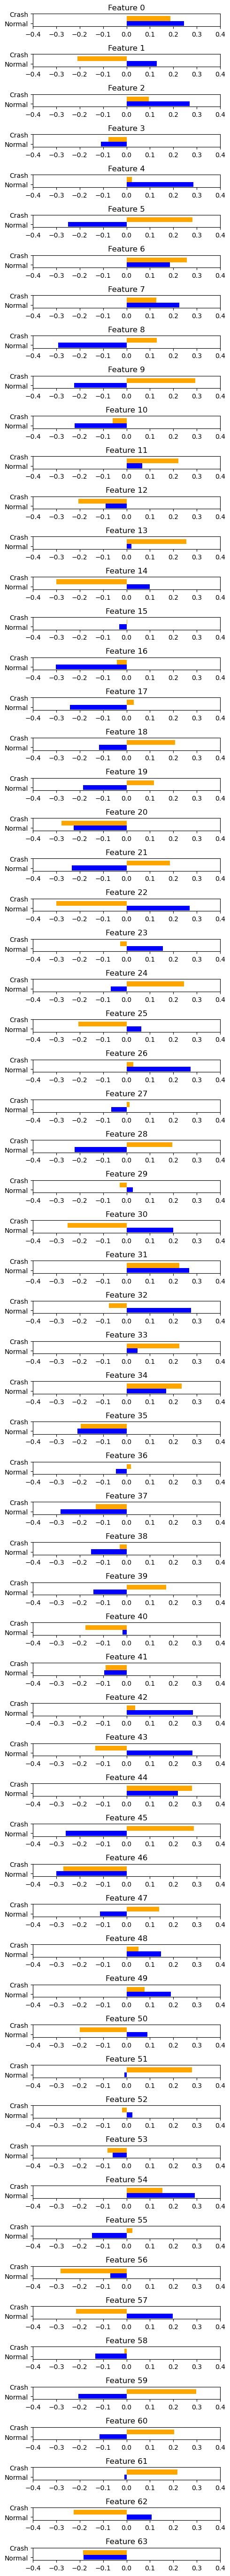

In [193]:
# Number of features
num_features = weights.shape[0]

# Prepare boundaries for each graph
bound = math.ceil(max(abs(np.max(weights)), abs(np.min(weights)))*10)/10

# Plotting 

fig, axs = plt.subplots(num_features, 1, figsize=(5, 55))  #Adjust size as needed

for i in range(num_features):
    index = np.arange(2)
    bar_height = 0.5
    offset = np.array([0, bar_height])
    axs[i].barh(index-offset, weights[i, :], bar_height, color=['blue', 'orange'])
    axs[i].set_yticks(index)
    axs[i].set_yticklabels(['Normal', 'Crash'])
    axs[i].set_title('Feature {}'.format(i))

    # Setting x-axis 
    axs[i].set_xlim([-bound, bound])

plt.tight_layout()
plt.show()

### What can we tell?



### (iii) For each feature, which feature does it tend more to contribute to? [Graphs of Comparison]

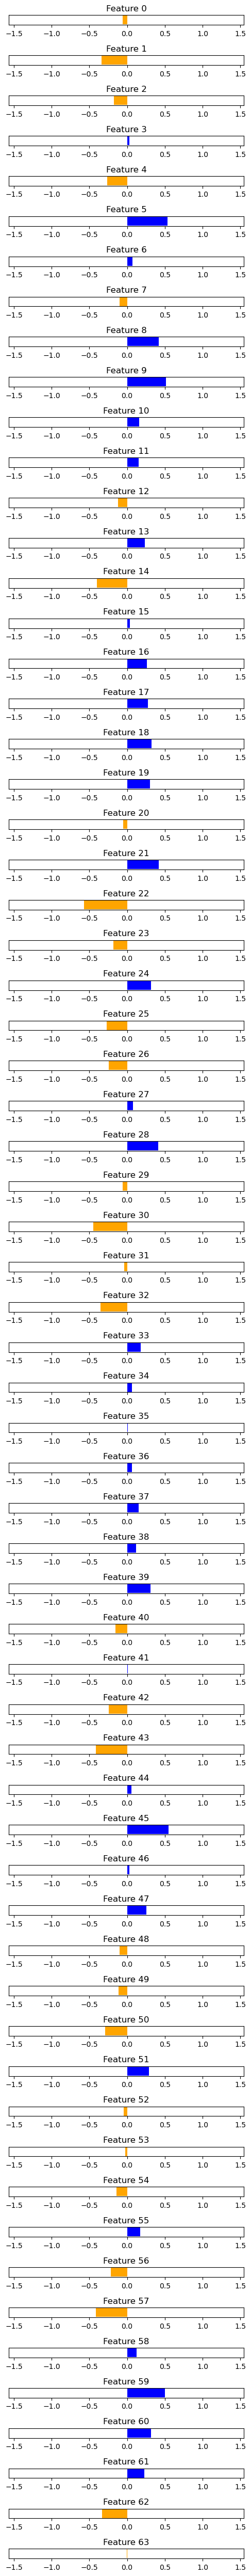

In [183]:
# Calculate the differences: Crash - Normal
differences = weights[:, 1] - weights[:, 0]

# Number of features
num_features = weights.shape[0]

# Set bound
bound = math.ceil(np.max(differences)*10)/10

# Creating the plot
fig, axs = plt.subplots(64, 1, figsize=(5, 50))  # Adjust size as needed

for i in range(num_features):
    axs[i].barh(0, differences[i], color='blue' if differences[i] >= 0 else 'orange')
    axs[i].set_title('Feature {}'.format(i))
    axs[i].set_xlim([differences.min() - 1, differences.max() + 1])
    axs[i].axes.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()

### What can we tell?



### (iv) What if we select a fix set of features? (GELU)

In [220]:
def gelu(x):
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))

In [227]:
# Separate the `differences` into those that contribute more to the normal class or crash class
tend_normal = abs(differences[differences<0])
tend_crash = abs(differences[differences>0])

# Select a number
x = 2

# Select the top x features' indicies that contribute more to either of the class
tend_normal_top_x_indices = np.argsort(tend_normal)[-x:][::-1]
tend_crash_top_x_indices = np.argsort(tend_crash)[-x:][::-1]
selected_weights_indices = np.concatenate((tend_normal_top_x_indices, tend_crash_top_x_indices))
# selected_weights = weights[selected_weights_indices]

# Biases
# biases

# I have the biases and the weight matrix for binary classification. 
# How should I apply the GELU with those information?

In [229]:
from tensorflow.keras.callbacks import Callback

class ApplyMaskCallback(Callback):
    def __init__(self, mask, layer_index):
        super().__init__()
        self.mask = mask
        self.layer_index = layer_index

    def on_batch_end(self, batch, logs=None):
        weights = self.model.layers[self.layer_index].get_weights()
        weights[0] *= self.mask  # Apply mask to weights, not biases
        self.model.layers[self.layer_index].set_weights(weights)

layer_index = -1 # last layer
mask = np.ones_like(model.layers[layer_index].get_weights()[0])
mask = np.zeros((EMBED_DIM, NUM_CLASSES))
mask[selected_weights_indices, :] = 1
callback = ApplyMaskCallback(mask, layer_index=layer_index)
callback

In [234]:
model_new, history_new = run_experiment(callback=callback)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 47s 9s/step - accuracy: 0.3156 - loss: 1.0139 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 1.0755 - val_top-5-accuracy: 1.0000
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 47s 9s/step - accuracy: 0.8422 - loss: 0.5434 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 1.0226 - val_top-5-accuracy: 1.0000
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 9s/step - accuracy: 0.8000 - loss: 0.4975 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 0.8920 - val_top-5-accuracy: 1.0000
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 48s 9s/step - accuracy: 0.7306 - loss: 0.4424 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 1.0281 - val_top-5-accuracy: 1.0000
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 50s 10s/step - accuracy: 0.8080 - loss: 0.3533 - top-5-accuracy: 1.0000 - val_accuracy: 0.5000 - val_loss: 1.3307 - val_top-5-accuracy: 1.0000


**Why using callback?**

Selectively zero out weights in a specific layer (last layer) of a neural network during training

Allowing the model to only learn using the unmasked weights during that last layer. 

This is useful for testing the impact of specific features or weights on model performance.

### 2.3 Confusion Matrix (TF vs. TN vs. FP vs. FN) 

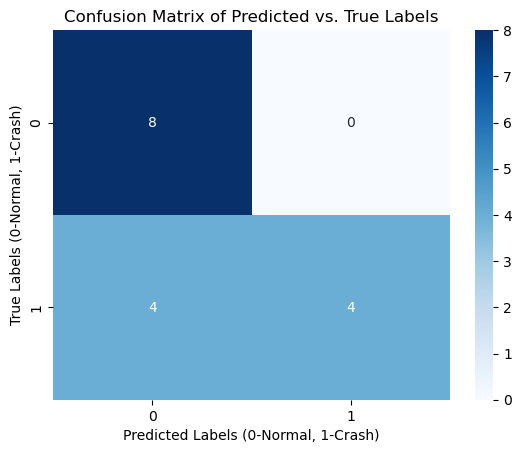

In [224]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

true = [1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0]

cm = confusion_matrix(true, pred)

# Visualize the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels (0-Normal, 1-Crash)')
plt.ylabel('True Labels (0-Normal, 1-Crash)')
plt.title('Confusion Matrix of Predicted vs. True Labels')
plt.show()

### 2.4 Multi-Head Attention

In [58]:
# Here are the indicies of the misclassified test videos
misclassified = []
for i in range(len(pred)):
    if pred[i] != true[i]:
        misclassified.append(i)
misclassified

[2, 4, 5, 7]

In [74]:
# How do we visualize it?

"""

Attention Scores Calculation: 
The attention mechanism calculates scores by performing a dot product of the query with all keys for each head.
These scores determine how much focus (or attention) should be given to other parts of the input.

Aggregated Information: Each element in the output tensor represents an aggregation of information 
from other parts of the input, weighted by the calculated attention scores.


You can aggregate attention weights across different frames to see 
if there's a temporal pattern in how the model attends to different regions of the video.

Generate heatmaps for individual frames 
or average them across a sequence to visually 
represent where the model is "looking."

"""

# attention.shape  # (1, 1536, 64) 
# (Batch Size (1), Num of Tokens (1526), Embedding Dimension (64))

In [59]:
""" REFERENCE

EMBED_DIM = 64
PATCH_SIZE = 8,8,8
INPUT_SHAPE = (50, 128, 128, 1)
NUM_HEADS = 6

"""

# The below codes are similar to the codes in line 33-62 
#              in the `create_vivit_classifier` function

def preprocess_frames(frames: tf.Tensor):
    """Preprocess the frames tensors for prediction."""
    frames = tf.image.convert_image_dtype(
        frames[..., tf.newaxis],
        tf.float32,
    )
    return frames

# Define the model up to the attention layer
# The below codes are similar to the codes in line 33-62 
#              in the `create_vivit_classifier` function

inputs = layers.Input(shape=INPUT_SHAPE)
tubelet_embedder = TubeletEmbedding(embed_dim=EMBED_DIM, patch_size=PATCH_SIZE)
patches = tubelet_embedder(inputs)
positional_encoder = PositionalEncoder(embed_dim=EMBED_DIM)
encoded_patches = positional_encoder(patches)
x = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
multi_head_attention = tf.keras.layers.MultiHeadAttention(num_heads=NUM_HEADS, key_dim=EMBED_DIM)
attention_output = multi_head_attention(x, x)

# Model Building

model = models.Model(inputs=inputs, outputs=attention_output)

# Assuming test_videos[0] is a numpy array and needs to be converted to a TensorFlow tensor

video_tensor = tf.convert_to_tensor(test_videos[0], dtype=tf.float32)
preprocessed_video = preprocess_frames(video_tensor)
preprocessed_video = tf.expand_dims(preprocessed_video, axis=0)
attention = model.predict(preprocessed_video)

print(attention)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[[[-0.08645728 -0.01818185  0.04557808 ... -0.04915994 -0.04159524
   -0.08774397]
  [-0.08934183 -0.01717143  0.04743646 ... -0.04901168 -0.04305458
   -0.0882909 ]
  [-0.08716104 -0.01761697  0.04638793 ... -0.04908247 -0.0438057
   -0.08836776]
  ...
  [-0.08782692 -0.01826489  0.04688556 ... -0.04904728 -0.04409932
   -0.08871816]
  [-0.08846837 -0.01867196  0.04675393 ... -0.04941053 -0.04264785
   -0.08832578]
  [-0.08785257 -0.01790616  0.04598612 ... -0.0492804  -0.04219846
   -0.08789608]]]
